In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, auc, precision_recall_curve

In [18]:
data = pd.read_csv("online_retail_preprocessed.csv")

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InvoiceNo         2200 non-null   object 
 1   StockCode         2200 non-null   object 
 2   Description       2200 non-null   object 
 3   Quantity          2200 non-null   int64  
 4   InvoiceDate       2200 non-null   object 
 5   UnitPrice         2200 non-null   float64
 6   CustomerID        2200 non-null   float64
 7   Country           2200 non-null   object 
 8   is_anomaly        2200 non-null   int64  
 9   Total_Price       2200 non-null   float64
 10  InvoiceHour       2200 non-null   int64  
 11  InvoiceDayOfWeek  2200 non-null   int64  
 12  InvoiceMonth      2200 non-null   int64  
 13  InvoiceYear       2200 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 240.8+ KB


In [45]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_anomaly,Total_Price,InvoiceHour,InvoiceDayOfWeek,InvoiceMonth,InvoiceYear,anomaly_prediction,anomaly_score,final_anomaly_prediction,final_anomaly_score,final_anomaly_prediction_binary,Fraud_Risk_Score,Total_Price_log,Quantity_log
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,0,20.40,12,2,6,2011,1,0.174351,1,0.200759,0,3.946173,3.063391,3.218876
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,0,27.80,17,4,5,2011,1,0.106869,1,0.133277,0,20.937133,3.360375,1.609438
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,0,2.60,17,3,4,2011,1,0.137300,1,0.163708,0,13.275047,1.280934,1.609438
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,0,5.85,10,2,11,2011,1,0.165952,1,0.192360,0,6.060802,1.924249,1.386294
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom,0,19.90,8,3,3,2011,1,0.070392,1,0.096800,0,30.121416,3.039749,1.098612
5,576200,82482,WOODEN PICTURE FRAME WHITE FINISH,2,2011-11-14 12:14:00,2.95,15572.0,United Kingdom,0,5.90,12,0,11,2011,1,0.156312,1,0.182721,0,8.487928,1.931521,1.098612
6,577076,22614,PACK OF 12 SPACEBOY TISSUES,12,2011-11-17 15:08:00,0.39,14362.0,United Kingdom,0,4.68,15,3,11,2011,1,0.167716,1,0.194124,0,5.616679,1.736951,2.564949
7,568909,22596,CHRISTMAS STAR WISH LIST CHALKBOARD,12,2011-09-29 13:38:00,1.25,16818.0,United Kingdom,0,15.00,13,3,9,2011,1,0.186625,1,0.213034,0,0.855613,2.772589,2.564949
8,578072,21109,LARGE CAKE TOWEL CHOCOLATE SPOTS,1,2011-11-22 16:02:00,6.75,17759.0,United Kingdom,0,6.75,16,1,11,2011,1,0.138039,1,0.164448,0,13.088800,2.047693,0.693147
9,560491,23297,SET 40 HEART SHAPE PETIT FOUR CASES,2,2011-07-19 10:51:00,1.65,12415.0,Australia,0,3.30,10,1,7,2011,1,0.156870,1,0.183278,0,8.347516,1.458615,1.098612


In [20]:
features_used = [
    'Quantity',
    'UnitPrice',
    'Total_Price',
    'InvoiceHour',
    'InvoiceDayOfWeek',
    'InvoiceMonth',
    'InvoiceYear'
]

In [21]:
X = data[features_used]
y_true = data["is_anomaly"]

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_used, index=data.index)

In [51]:
best_roc_auc = -1
best_params = {}
results = []

contamination_value = 0.05
n_estimators_options = [100, 150, 200]

for n_est in n_estimators_options:
    model = IsolationForest(
        n_estimators=n_est,
        contamination=contamination_value,
        random_state=42,
        max_features=1.0,
        max_samples='auto'
    )
    model.fit(X_scaled_df)

    data['anomaly_prediction'] = model.predict(X_scaled_df)
    data['anomaly_score'] = model.decision_function(X_scaled_df)
    y_pred = np.array([1 if p == -1 else 0 for p in data['anomaly_prediction']])

    roc_auc = roc_auc_score(y_true, -data['anomaly_score'])
    precision, recall, _ = precision_recall_curve(y_true, -data['anomaly_score'])
    pr_auc = auc(recall, precision)

    print(f"n_estimators: {n_est}")
    print(f"  ROC AUC Score: {roc_auc:.4f}")
    print(f"  PR AUC Score: {pr_auc:.4f}")
    print("  Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

    results.append({
        'n_estimators': n_est,
        'contamination': contamination_value,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'report': classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'], output_dict=True)
    })

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_params = {'n_estimators': n_est, 'contamination': contamination_value}


n_estimators: 100
  ROC AUC Score: 0.9979
  PR AUC Score: 0.9605
  Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      2105
     Anomaly       0.81      0.94      0.87        95

    accuracy                           0.99      2200
   macro avg       0.90      0.96      0.93      2200
weighted avg       0.99      0.99      0.99      2200

n_estimators: 150
  ROC AUC Score: 0.9989
  PR AUC Score: 0.9768
  Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      2105
     Anomaly       0.84      0.97      0.90        95

    accuracy                           0.99      2200
   macro avg       0.92      0.98      0.95      2200
weighted avg       0.99      0.99      0.99      2200

n_estimators: 200
  ROC AUC Score: 0.9991
  PR AUC Score: 0.9788
  Classification Report:
              precision    recall  f1-score   support

      Normal       1.

In [52]:
final_model = IsolationForest(
    n_estimators=best_params['n_estimators'],
    contamination=best_params['contamination'],
    random_state=42,
    max_features=1.0,
    max_samples='auto'
)
final_model.fit(X_scaled_df)

data['final_anomaly_prediction'] = final_model.predict(X_scaled_df)
data['final_anomaly_score'] = final_model.decision_function(X_scaled_df)

data['final_anomaly_prediction_binary'] = np.array([1 if p == -1 else 0 for p in data['final_anomaly_prediction']])

risk_scaler = MinMaxScaler(feature_range=(0, 100))
data['Fraud_Risk_Score'] = risk_scaler.fit_transform((-data['final_anomaly_score']).values.reshape(-1, 1))

print(classification_report(y_true, data['final_anomaly_prediction_binary'], target_names=['Normal', 'Anomaly']))
print(f"ROC AUC Model Final: {roc_auc_score(y_true, -data['final_anomaly_score']):.4f}")

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      2105
     Anomaly       0.85      0.98      0.91        95

    accuracy                           0.99      2200
   macro avg       0.92      0.99      0.95      2200
weighted avg       0.99      0.99      0.99      2200

ROC AUC Model Final: 0.9991


#Skor Risiko Fraud

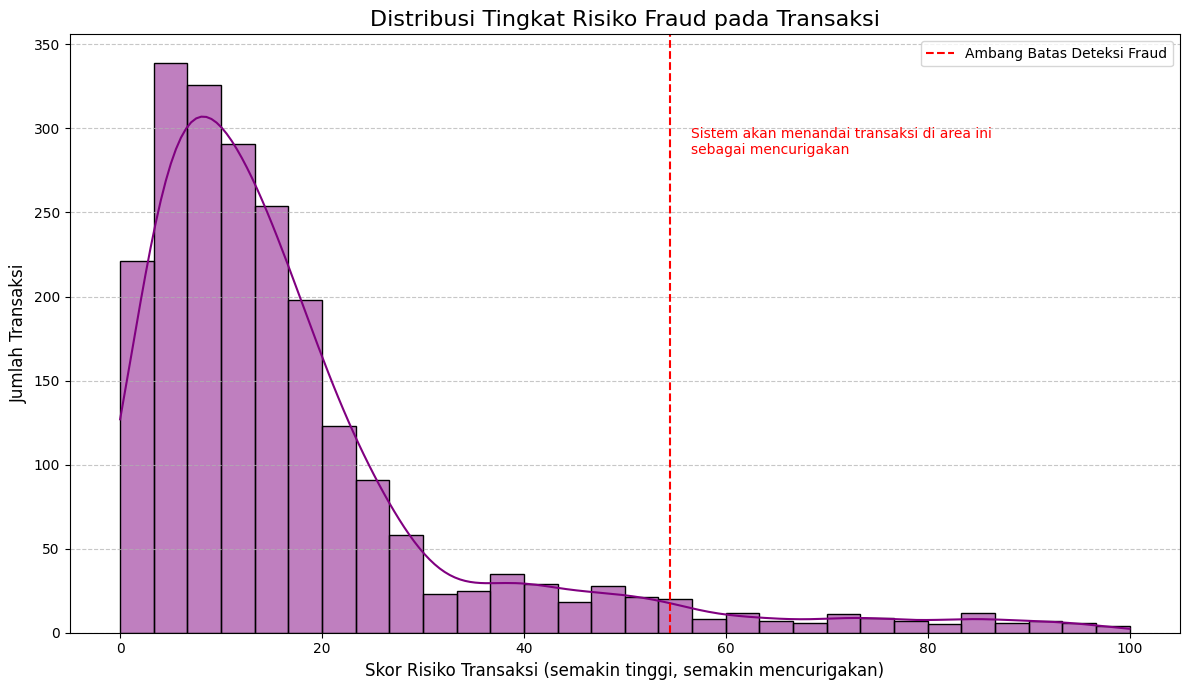

In [53]:
plt.figure(figsize=(12, 7))

threshold = data[data['final_anomaly_prediction_binary'] == 1]['Fraud_Risk_Score'].min()

sns.histplot(data['Fraud_Risk_Score'], bins=30, kde=True, color='purple')
plt.title('Distribusi Tingkat Risiko Fraud pada Transaksi', fontsize=16)
plt.xlabel('Skor Risiko Transaksi (semakin tinggi, semakin mencurigakan)', fontsize=12)
plt.ylabel('Jumlah Transaksi', fontsize=12)

plt.axvline(x=threshold, color='red', linestyle='--', label='Ambang Batas Deteksi Fraud')
plt.text(threshold + 2, plt.ylim()[1]*0.8,
         'Sistem akan menandai transaksi di area ini\nsebagai mencurigakan',
         color='red', fontsize=10)

plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('fraud_risk_score_distribution.png')
plt.show()


#Pola Fraud vs Normal

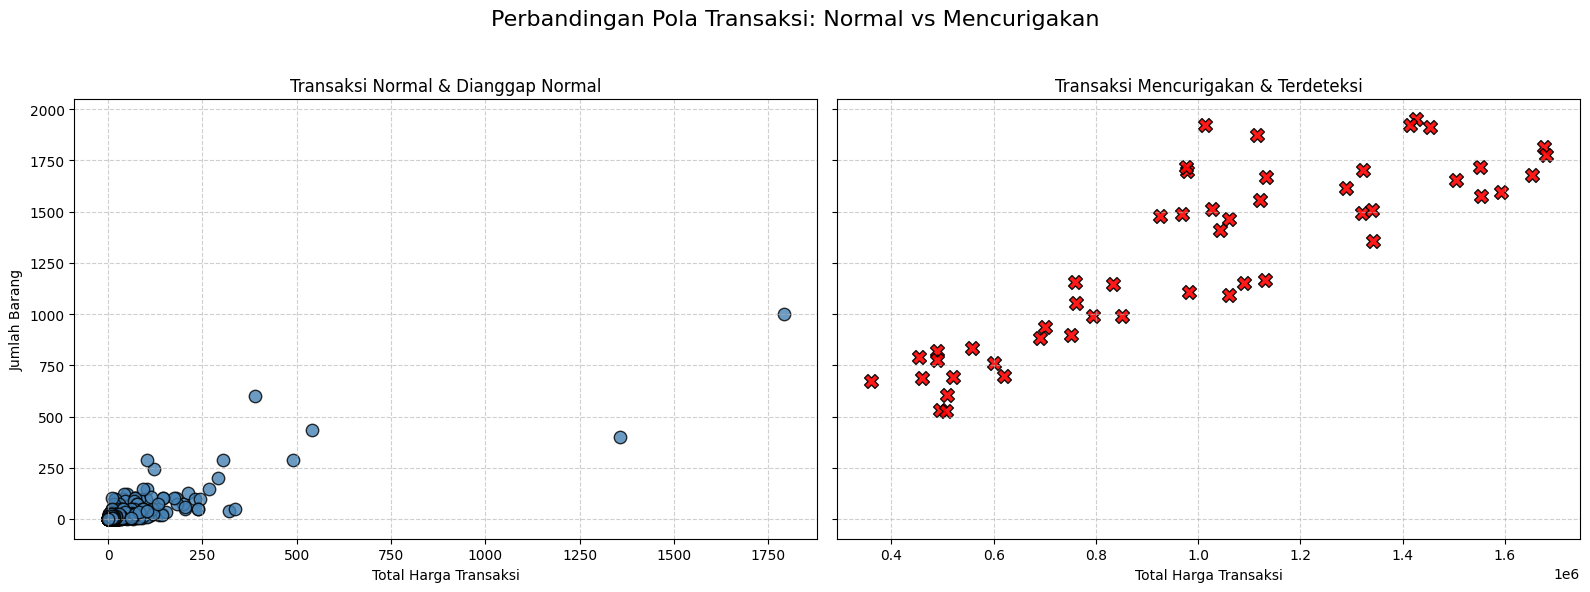

In [54]:

def get_status(row):
    if row['is_anomaly'] == 0 and row['final_anomaly_prediction_binary'] == 0:
        return 'Normal & Dianggap Normal'
    elif row['is_anomaly'] == 1 and row['final_anomaly_prediction_binary'] == 1:
        return 'Mencurigakan & Terdeteksi'
    else:
        return 'Lainnya'

data['Status_Prediksi'] = data.apply(get_status, axis=1)

df_plot = data[(data['Quantity'] > 0) & (data['Total_Price'] > 0)].copy()
df_normal = df_plot[df_plot['Status_Prediksi'] == 'Normal & Dianggap Normal']
df_anomaly = df_plot[df_plot['Status_Prediksi'] == 'Mencurigakan & Terdeteksi']


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axes[0].scatter(df_normal['Total_Price'], df_normal['Quantity'],
                c='steelblue', edgecolor='black', s=80, alpha=0.8)
axes[0].set_title("Transaksi Normal & Dianggap Normal")
axes[0].set_xlabel("Total Harga Transaksi")
axes[0].set_ylabel("Jumlah Barang")
axes[0].grid(True, linestyle='--', alpha=0.6)


axes[1].scatter(df_anomaly['Total_Price'], df_anomaly['Quantity'],
                c='red', marker='X', edgecolor='black', s=100, alpha=0.9)
axes[1].set_title("Transaksi Mencurigakan & Terdeteksi")
axes[1].set_xlabel("Total Harga Transaksi")
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Perbandingan Pola Transaksi: Normal vs Mencurigakan", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#Contoh Data yang Tercatat Fraud atau Mencurigakan

In [49]:
top_20_risky = data.sort_values(by='Fraud_Risk_Score', ascending=False).head(20)
display_cols = ['InvoiceNo', 'Description', 'Quantity', 'UnitPrice', 'Total_Price', 'Country', 'Fraud_Risk_Score', 'final_anomaly_prediction_binary', 'is_anomaly']
print(top_20_risky[display_cols].to_string(index=False))

InvoiceNo                         Description  Quantity  UnitPrice  Total_Price        Country  Fraud_Risk_Score  final_anomaly_prediction_binary  is_anomaly
   537823          RIBBON REEL HEARTS DESIGN       1598 996.146214 1.591842e+06 United Kingdom        100.000000                                1           1
   547083      VINTAGE BILLBOARD DRINK ME MUG      1681 984.039672 1.654171e+06 United Kingdom         98.482354                                1           1
   539447                DOLLY GIRL LUNCH BOX      1511 679.259125 1.026361e+06        Belgium         98.169625                                1           1
   550514            PAPER BUNTING WHITE LACE      1775 947.186051 1.681255e+06 United Kingdom         98.011292                                1           1
   550799    VINTAGE CREAM DOG FOOD CONTAINER      1815 923.918639 1.676912e+06 United Kingdom         96.254392                                1           1
   548458       DOORMAT HOME SWEET HOME BLUE       1